In [1]:
import sys
pip3_path = '.local/lib/python3.5/site-packages'
if pip3_path not in sys.path:
    sys.path.append(pip3_path)

# general
import sys
import pandas as pd
import numpy as np
import random
import requests
import os
import matplotlib
import matplotlib.pyplot as plt
import tarfile
from zipfile import ZipFile
from time import time
from pprint import pprint
from glob import glob

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn, wordnet as wn
from nltk.stem.lancaster import LancasterStemmer
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('sentiwordnet')

# other
from afinn import Afinn
from textblob.en.sentiments import PatternAnalyzer as TextBlobPatternAnalyzer
from textblob.en.sentiments import NaiveBayesAnalyzer as TextBlobNaiveBayesAnalyzer

[nltk_data] Downloading package vader_lexicon to C:\Users\asus tuf
[nltk_data]     gaming\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\asus tuf
[nltk_data]     gaming\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\asus tuf
[nltk_data]     gaming\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to C:\Users\asus tuf
[nltk_data]     gaming\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [2]:
def load_long_docs(max_docs_per_label=np.inf):

    if not os.path.exists('aclImdb_v1.tar.gz'):
       
        print('Downloading long docs...')
        response = requests.get('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')

        with open('aclImdb_v1.tar.gz', 'wb') as f:  
            f.write(response.content)

    else:
        print('Long docs already downloaded.')
        
    if not os.path.exists('long_docs'):
       
        print('Extracting long docs...')
        with tarfile.open('aclImdb_v1.tar.gz') as tar:
            tar.extractall('long_docs')
            tar.close()

    else:
        print('Long docs already extracted.')


    print('Reading long docs...')

    pos_sentences, neg_sentences = [], []

    count = 0
    for path in glob('long_docs/aclImdb/*/neg/*.txt'):
        with open(path, 'r', errors = "replace") as f:
            text = f.read()
            neg_sentences.append(text)
            count += 1
            if count >= max_docs_per_label:
                break

    count = 0
    for path in glob('long_docs/aclImdb/*/pos/*.txt'):
        with open(path, 'r', errors = "replace") as f:
            text = f.read()
            pos_sentences.append(text)
            count += 1
            if count >= max_docs_per_label:
                break

    return {'pos': pos_sentences, 'neg': neg_sentences}

def load_short_docs():

    if not os.path.exists('short_docs'):
       
        print('Downloading short docs...')
        response = requests.get('http://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment labelled sentences.zip')

        with open('short_docs.zip', 'wb') as f:  
            f.write(response.content)
           
        ZipFile('short_docs.zip').extractall('short_docs')
        print('Short docs downloaded.')
   
    else:

        print('Short docs already downloaded.')
   
    pos_sentences, neg_sentences = [], []

    # pandas.read_csv failed to process one of the files correctly, hence this manual approach.
    for path in glob('short_docs/sentiment labelled sentences/*labelled.txt'):
        with open(path, 'r') as f:
            pairs = [line.split('\t') for line in f.readlines()]
            for pair in pairs:
                if int(pair[1]):
                    pos_sentences.append(pair[0])
                else:
                    neg_sentences.append(pair[0])

    return {'pos': pos_sentences, 'neg': neg_sentences}

def print_doc_counts(doc_sets):
   
    for key1 in doc_sets:
        for key2 in doc_sets[key1]:
            print(key1, key2, len(doc_sets[key1][key2]))
            
# Next, we'll call our functions to load the long and short corpora. If you have your own corpus readily available, you can add it to the full_doc_sets collection below, and it will automatically be included in the tests that follow.

# The long corpus is quite large and takes a long time to train models on. You can choose to load fewer than the 50,000 documents by specifying the optional parameter max_docs_per_label, but you'll also have an option later in the script to train on only a subset of whatever you have downloaded.

full_doc_sets = {'Long': load_long_docs(), # (max_docs_per_label=5000) # optionally, limit size for faster loading
                 'Short': load_short_docs(),
               # 'Your corpus here': {'pos': [...your positive docs...], 'neg': [...your negative docs...]}
                }

doc_set_names = full_doc_sets.keys()

print('Downloads complete.')
print_doc_counts(full_doc_sets)

Long docs already downloaded.
Long docs already extracted.
Reading long docs...
Short docs already downloaded.
Downloads complete.
Long pos 25000
Long neg 25000
Short pos 1500
Short neg 1500


In [3]:
full_doc_sets = {'Long': load_long_docs(), # (max_docs_per_label=5000) # optionally, limit size for faster loading
                 'Short': load_short_docs(),
               # 'Your corpus here': {'pos': [...your positive docs...], 'neg': [...your negative docs...]}
                }

doc_set_names = full_doc_sets.keys()

print('Downloads complete.')
print_doc_counts(full_doc_sets)

Long docs already downloaded.
Long docs already extracted.
Reading long docs...
Short docs already downloaded.
Downloads complete.
Long pos 25000
Long neg 25000
Short pos 1500
Short neg 1500


In [4]:
global_results = {}

train_doc_sets = {key: {} for key in full_doc_sets}
test_doc_sets = {key: {} for key in full_doc_sets}


for name in doc_set_names:
    for label in ['pos', 'neg']:
        train, test = train_test_split(full_doc_sets[name][label], test_size = 0.2)
        train_doc_sets[name][label], test_doc_sets[name][label] = train, test
        
print('Train:')
print_doc_counts(train_doc_sets)
print('Test: ')
print_doc_counts(test_doc_sets)

Train:
Long pos 20000
Long neg 20000
Short pos 1200
Short neg 1200
Test: 
Long pos 5000
Long neg 5000
Short pos 300
Short neg 300


In [48]:
tr = train_doc_sets['Long']
tr_pos = tr['pos']

In [57]:
type(tr_pos)

list

In [5]:
def geometric_mean_accuracy(truth, preds):
    df = pd.DataFrame(data={'truth': truth, 'preds': preds})
   
    true_pos = sum(df['truth'] & df['preds']) # bitwise and
    true_neg = sum(~df['truth'] & ~df['preds']) # bitwise and on (bitwise not)
    all_pos = sum(df['truth']) # sums all values of df["truth"]
    all_neg = sum(~df['truth']) # sums all values of bitwise not df['truth']
   
    result = np.sqrt((true_pos / all_pos) * (true_neg / all_neg))
    return result


def print_results(results=global_results, group=None):

    if results is None or len(results) == 0:
        return
   
    df = pd.DataFrame(results).transpose()
    if group is not None:
        df = df[df['_group'] == group]
    df = df.drop('_group', axis=1)
    df = df.reset_index()
    df = df.set_index(['_doc_set', '_method'])
    df = df.rename_axis(('Corpus', 'Method'))
    df = df.drop('index', axis=1)
    df = df.sort_index()
    df = df.astype(float).round(3)
    df['Docs/sec'] = df['Docs/sec'].astype(int)
    df = df[['Accuracy', 'GM accuracy', 'Docs/sec']]
   
    display(df)
    
def build_result(group, method, doc_set_name, start, stop, truth, preds):

    key = '{}_{}_{}'.format(method, group, doc_set_name)
   
    result = {key : {'_group': group,
                     '_method': method,
                     '_doc_set': doc_set_name,
                     'GM accuracy': None if truth is None else geometric_mean_accuracy(truth, preds),
                     'Accuracy': None if truth is None else accuracy_score(truth, preds),
                     'Docs/sec': None if truth is None else len(truth) / (stop - start),
                   # 'Your measurement': ...
                    }}
   
    global_results.update(result)
    return result
   
def run_test(group, method, doc_sets, func, max_records_per_label=np.nan):
   
    local_results = {}
   
    for doc_set_name, doc_set in doc_sets.items():
       
        pos_docs, neg_docs = doc_set['pos'], doc_set['neg']
        if len(pos_docs) > max_records_per_label:
            pos_docs = random.sample(pos_docs, max_records_per_label)
        if len(neg_docs) > max_records_per_label:
            neg_docs = random.sample(neg_docs, max_records_per_label)

        start = time()
        preds = [func(doc) for doc in pos_docs + neg_docs]
        stop = time()

        truth = [True] * len(pos_docs) + [False] * len(neg_docs)
       
        result = build_result(group, method, doc_set_name, start, stop, truth, preds)
        local_results.update(result)
   
    print_results(local_results, group=group)
    
def plot_results(group, var_names=None, title='', round_digits=0, relative=False, lower_limit=None, upper_limit=None):

    for doc_set_name in sorted(doc_set_names):

        df = pd.DataFrame(global_results).transpose()
        df = df[df._doc_set == doc_set_name]
        df = df[df._group == group]
        if len(df) == 0:
            print('No results.')
            return
       
        if var_names is None:
            var_names = [x for x in df.columns if not x.startswith('_')]

        df = df.sort_index(ascending=False)
        methods = df._method.values
        df = df[list(reversed(var_names))]
        orig_df = df.copy() # the dataframe may get scaled so we need to preserve the original values

        lower_limit_, upper_limit_ = lower_limit, upper_limit
        if relative:
            df = df / df.max()
            lower_limit_ = 0
            upper_limit_ = 1.1
        else:
            lower_limit_ = df.values.min() * 0.9 if lower_limit is None else lower_limit
            upper_limit_ = df.values.max() * 1.15 if upper_limit is None else upper_limit

        positions = np.arange(len(df.columns))
        bars_per_bar_group = len(df)
        bar_width = 0.8 / bars_per_bar_group
        bar_start = -bars_per_bar_group / 2 + 0.5

        fig, ax = plt.subplots(figsize = [10, df.size * .3 + .3])
        plt.title("{} (Group='{}', Corpus='{}')".format(title, group, doc_set_name), fontsize=14)
        bar_pos = bar_start

        min_value, max_value = float('inf'), float('-inf')
        for i, col in enumerate(df.index.values):
            bar = ax.barh(positions + bar_pos * bar_width, df.loc[col, :], bar_width, label=' '+methods[i])
            for rect, value in zip(bar, orig_df.loc[col, :]):
                if round_digits == 0:
                    value = int(value)
                else:
                    value = round(value, round_digits)
                ax.text(rect.get_x() + rect.get_width(), rect.get_y() + rect.get_height() / 2,
                        ' ' + str(value), ha='left', va='center', color='black', weight='medium')
            bar_pos += 1

        ax.set_yticks(range(len(df.columns)))
        ax.set_yticklabels(df.columns.values)
        ax.set_xlim([lower_limit_, upper_limit_])
        if relative:
            ax.set_xticks([])
            ax.set_xticklabels([])
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

In [6]:
af = Afinn()

print(af.score("What a miserable waste of time"))
print(af.score("Brilliant!"))
print(af.score("Hello World!"))

-4.0
4.0
0.0


In [7]:
print(af.score("It was not good."))
print(af.score("In your dreams was it worth the money"))

-2.0
3.0


In [8]:
af = Afinn()

run_test("Out of the box", 'Afinn', full_doc_sets, lambda x: af.score(x) > 0, max_records_per_label = 2500)

,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,Afinn,0.707,0.696,161
Short,Afinn,0.780,0.780,3191


In [9]:
import nltk
nltk.download('omw-1.4')

def score_sentiwordnet(doc):
   
    synsets = (wn.synsets(w) for w in word_tokenize(doc) if w is not None) # tokenize and lookup synonyms in WordNet
    words = (s[0].name() for s in synsets if s is not None and len(s) > 0) # use the first (most common) synonym
    words = (swn.senti_synset(s) for s in words) # get sentiment scores which have pos, neg, and neutral parts
    scores = ((1 - w.obj_score()) * (w.pos_score() - w.neg_score()) for w in words) # compute individual word scores
    return (sum(scores) > 0) # classify document as positive if resulting score is positive

run_test('Out of the box', 'SentiWordNet', full_doc_sets, lambda x: score_sentiwordnet(x), max_records_per_label=2500)

[nltk_data] Downloading package omw-1.4 to C:\Users\asus tuf
[nltk_data]     gaming\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,SentiWordNet,0.665,0.654,144
Short,SentiWordNet,0.674,0.673,2396


In [10]:
pa = TextBlobPatternAnalyzer()

run_test('Out of the box', 'TextBlob (Pattern)', full_doc_sets, lambda x: pa.analyze(x)[0] > 0, max_records_per_label=2500)

,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,TextBlob (Pattern),0.685,0.634,868
Short,TextBlob (Pattern),0.778,0.778,6635


In [11]:
sia = SentimentIntensityAnalyzer()

run_test('Out of the box', 'VADER', full_doc_sets, lambda x: sia.polarity_scores(x)['compound'] > 0, max_records_per_label=2500)

,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,VADER,0.697,0.678,517
Short,VADER,0.811,0.811,8114


In [12]:
print_results()

Accuracy  GM accuracy  Docs/sec
Corpus Method                                             
Long   Afinn                  0.707        0.696       161
       SentiWordNet           0.665        0.654       144
       TextBlob (Pattern)     0.685        0.634       868
       VADER                  0.697        0.678       517
Short  Afinn                  0.780        0.780      3191
       SentiWordNet           0.674        0.673      2396
       TextBlob (Pattern)     0.778        0.778      6635
       VADER                  0.811        0.811      8114

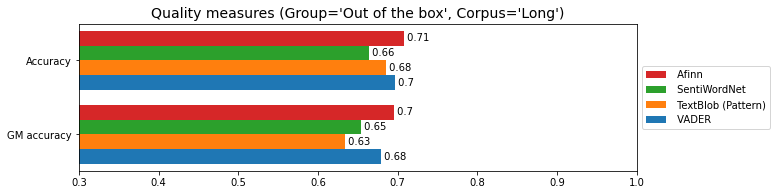

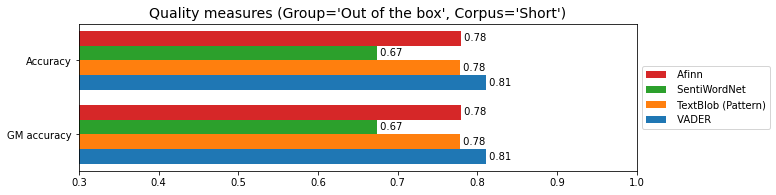

In [13]:
plot_results('Out of the box', var_names=['Accuracy', 'GM accuracy'], title='Quality measures', round_digits=2, lower_limit=0.3, upper_limit=1.0)

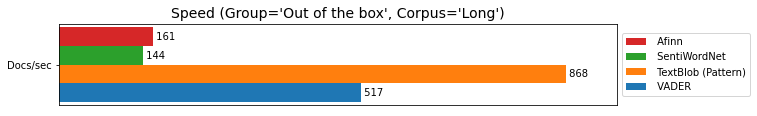

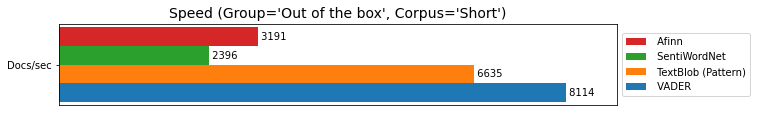

In [14]:
plot_results('Out of the box', var_names=['Docs/sec'], title='Speed', relative=True, lower_limit=0.3, upper_limit=1.0)

In [16]:
# Vectorizers

count_vectorizer = CountVectorizer()
corpus = ["The dog", "The person", "The cat"]
count_vectorizer.fit(corpus)

print(count_vectorizer.get_feature_names_out())
print(count_vectorizer.transform(corpus).toarray())

['cat' 'dog' 'person' 'the']
[[0 1 0 1]
 [0 0 1 1]
 [1 0 0 1]]


In [17]:
test_set = ["The one cat", "Person Dog Person"]

print(count_vectorizer.get_feature_names_out())
print(count_vectorizer.transform(corpus).toarray()) # Word that were not seen in the corpus are ignored

['cat' 'dog' 'person' 'the']
[[0 1 0 1]
 [0 0 1 1]
 [1 0 0 1]]


In [20]:
# TfidfVectroizer

corpus = ['The dog', 'The person', 'The cat']

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(corpus) # return a modified TfidfVectorizer object

print(tfidf_vectorizer.get_feature_names()) # get name of unique words
print(tfidf_vectorizer.transform(corpus).toarray().round(3)) # transforms the each element of the corpus into an array (not into 0 & 1; but value between 0 and 1)


['cat', 'dog', 'person', 'the']
[[0.    0.861 0.    0.509]
 [0.    0.    0.861 0.509]
 [0.861 0.    0.    0.509]]


In [21]:
test_set = ['The one cat', 'A person and a dog person']

print(tfidf_vectorizer.get_feature_names())
print(tfidf_vectorizer.transform(test_set).toarray().round(3))

['cat', 'dog', 'person', 'the']
[[0.861 0.    0.    0.509]
 [0.    0.447 0.894 0.   ]]


In [22]:
tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(train_doc_sets['Short']['pos'] + train_doc_sets['Short']['neg'])

In [23]:
print(tfidf_vectorizer.get_feature_names()[-5:]) # returns the last first elements in the feature vector
print(tfidf_vectorizer.transform(['zillion zillion zombie']).toarray()[0][-5:].round(3))

['yun', 'z500a', 'zero', 'zombie', 'zombiez']
[0. 0. 0. 1. 0.]


In [29]:
v = tfidf_vectorizer.transform(['the zillion zillion zombie']).toarray()
# print(len(v[0]))
v = v[v > 0.0]
print(v.round(3))

4515
[0.227 0.974]


In [33]:
y_train = [1] * len(train_doc_sets['Short']['pos']) + [0] * len(train_doc_sets['Short']['neg'])

In [34]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [35]:
X_test = tfidf_vectorizer.transform(test_doc_sets['Short']['pos'] + test_doc_sets['Short']['neg'])

In [36]:
y_preds = model.predict(X_test)

In [37]:
y_truth = [1] * len(test_doc_sets['Short']['pos']) + [0] * len(test_doc_sets['Short']['neg'])
print(accuracy_score(y_truth, y_preds).round(3))

0.822


In [58]:
def flex_train(doc_set_name, vectorizer, model, max_train_docs_per_label):

    pos_docs = train_doc_sets[doc_set_name]['pos']
    # pos_docs = pos_docs['pos']
    neg_docs = train_doc_sets[doc_set_name]['neg']
    # pos_docs = neg_docs['pos']

    if len(pos_docs) > max_train_docs_per_label: pos_docs = pos_docs[:max_train_docs_per_label]
    if len(neg_docs) > max_train_docs_per_label: neg_docs = neg_docs[:max_train_docs_per_label]

    X = np.abs(vectorizer.fit_transform(pos_docs + neg_docs))
    y = [True] * len(pos_docs) + [False] * len(neg_docs)

    model.fit(X, y)

def flex_predict(vectorizer, model, docs):

    X = np.abs(vectorizer.transform(docs))
    preds = model.predict(X)
    return preds

def flex_test(group, method, doc_set_name, vectorizer, model):

    pos_docs = test_doc_sets[doc_set_name]
    pos_docs = pos_docs['pos']
    neg_docs = test_doc_sets[doc_set_name]
    neg_docs = neg_docs['neg']

    truth = [True] * len(pos_docs) + [False] * len(neg_docs)

    start = time()
    preds = flex_predict(vectorizer, model, pos_docs + neg_docs)
    stop = time()

    return build_result(group, method, doc_set_name, start, stop, truth, preds)

def flex_train_and_test(group, method, vectorizer, model, max_train_docs_per_label=np.inf):

    local_results = {}

    for doc_set_name in doc_set_names:

        flex_train(doc_set_name, vectorizer, model, max_train_docs_per_label)
        result = flex_test(group, method, doc_set_name, vectorizer, model)
        local_results.update(result)
        global_results.update(result)

    return local_results

In [59]:
print_results(flex_train_and_test('Self-trained', 'TF-IDF + NB', TfidfVectorizer(), MultinomialNB(), max_train_docs_per_label=1000))

,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,TF-IDF + NB,0.822,0.817,7340
Short,TF-IDF + NB,0.815,0.815,99481
